In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
df = pd.read_csv('/content/consumer_complaints.csv')

In [3]:
df.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23403 entries, 0 to 23402
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   date_received                 23403 non-null  object 
 1   product                       23403 non-null  object 
 2   sub_product                   17645 non-null  object 
 3   issue                         23403 non-null  object 
 4   sub_issue                     9595 non-null   object 
 5   consumer_complaint_narrative  0 non-null      float64
 6   company_public_response       3 non-null      object 
 7   company                       23403 non-null  object 
 8   state                         23330 non-null  object 
 9   zipcode                       23331 non-null  object 
 10  tags                          3286 non-null   object 
 11  consumer_consent_provided     0 non-null      float64
 12  submitted_via                 23403 non-null  object 
 13  d

In [5]:
df['product'].value_counts()

Mortgage                   7602
Debt collection            5452
Credit reporting           3249
Bank account or service    2797
Credit card                2509
Student loan                724
Consumer Loan               694
Money transfers             206
Payday loan                 170
Name: product, dtype: int64

In [8]:
df.loc[df['product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
df.loc[df['product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
df.loc[df['product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
df.loc[df['product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'
df = df[df['product'] != 'Other financial service']

In [9]:
df['Product'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of Complaints', 
                                                                title='Number complaints in each product')

In [10]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = str(text).lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['consumer_complaint_narrative'] = df['consumer_complaint_narrative'].apply(clean_text)

In [11]:
df['consumer_complaint_narrative'] = df['consumer_complaint_narrative'].str.replace('\d+', '')

In [12]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['consumer_complaint_narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 1 unique tokens.


In [13]:
X = tokenizer.texts_to_sequences(df['consumer_complaint_narrative'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (23403, 250)


In [14]:
Y = pd.get_dummies(df['product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (23403, 9)


In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(21062, 250) (21062, 9)
(2341, 250) (2341, 9)


In [26]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(9, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 909       
Total params: 5,081,309
Trainable params: 5,081,309
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
epochs = 5
batch_size = 64
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
297/297 [==============================] - 218s 725ms/step - loss: 1.8244 - accuracy: 0.3247 - val_loss: 1.7672 - val_accuracy: 0.3204
Epoch 2/5
297/297 [==============================] - 214s 720ms/step - loss: 1.7739 - accuracy: 0.3214 - val_loss: 1.7593 - val_accuracy: 0.3204
Epoch 3/5
297/297 [==============================] - 215s 725ms/step - loss: 1.7680 - accuracy: 0.3247 - val_loss: 1.7592 - val_accuracy: 0.3204
Epoch 4/5
297/297 [==============================] - 217s 731ms/step - loss: 1.7555 - accuracy: 0.3306 - val_loss: 1.7677 - val_accuracy: 0.3204
Epoch 5/5
297/297 [==============================] - 217s 732ms/step - loss: 1.7643 - accuracy: 0.3306 - val_loss: 1.7657 - val_accuracy: 0.3204


In [28]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

74/74 [==============================] - 5s 62ms/step - loss: 1.7595 - accuracy: 0.3199
Test set
  Loss: 1.760
  Accuracy: 0.320


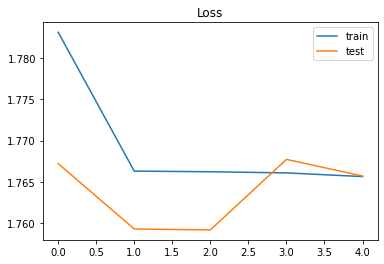

In [29]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [36]:
history.history

{'accuracy': [0.3232392370700836,
  0.3258243203163147,
  0.32592982053756714,
  0.32592982053756714,
  0.32592982053756714],
 'loss': [1.7830955982208252,
  1.766312837600708,
  1.7662346363067627,
  1.7660969495773315,
  1.7656532526016235],
 'val_accuracy': [0.3203606903553009,
  0.3203606903553009,
  0.3203606903553009,
  0.3203606903553009,
  0.3203606903553009],
 'val_loss': [1.7672171592712402,
  1.7593181133270264,
  1.75920569896698,
  1.7677301168441772,
  1.7657207250595093]}

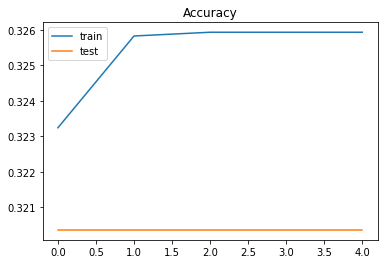

In [38]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

Test with a new complaint.

In [31]:
new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])

[[0.12707546 0.03590117 0.12422831 0.12614119 0.21292153 0.01115202
  0.32130128 0.00820463 0.03307439]] Checking or savings account
